In [ ]:
!git clone https://github.com/Text-Mining/Persian-Wikipedia-Corpus.git
!rm -rf "/content/Persian-Wikipedia-Corpus/Json Format of Persian Wikipedia Pages"
glove_path = "/content/Persian-Wikipedia-Corpus/models/glove"
!unzip /content/Persian-Wikipedia-Corpus/models/glove/vectors.zip -d /content/Persian-Wikipedia-Corpus/models/glove/

Cloning into 'Persian-Wikipedia-Corpus'...
remote: Enumerating objects: 47, done.
remote: Total 47 (delta 0), reused 0 (delta 0), pack-reused 47
Unpacking objects: 100% (47/47), done.
Checking out files: 100% (14/14), done.
Archive:  /content/Persian-Wikipedia-Corpus/models/glove/vectors.zip
  inflating: /content/Persian-Wikipedia-Corpus/models/glove/vectors.txt  


In [ ]:
# Install required packages

!pip install -q hazm
!pip install -q clean-text[gpl]
!pip install pyyaml==5.4.1

     |████████████████████████████████| 316 kB 8.8 MB/s 
     |████████████████████████████████| 233 kB 65.2 MB/s 
     |████████████████████████████████| 1.4 MB 60.9 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 175 kB 14.6 MB/s 
     |████████████████████████████████| 235 kB 61.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 636 kB 8.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Import required packages

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
!gdown --id 1YFEJVXIGxuQ1wiWY2gL7uJJ1QEl3SDXS

In [ ]:
# from huggingface_hub.hf_api import DatasetInfo
import json
# Opening JSON file
f = open('/dataset_annotated_impact.json')
# returns JSON object as
# a dictionary
dataset = json.load(f)

In [ ]:
# Train
train_text=[data["text"] for data in dataset["train"] if len(data["annotations"])!=0]
train_label = [data["annotations"] for data in dataset["train"] if len(data["annotations"])!=0]
train_label = list(map(lambda lst:max(set(lst), key=lst.count), train_label))
# Eval
eval_text=[data["text"] for data in dataset["eval"] if len(data["annotations"])!=0]
eval_label = [data["annotations"] for data in dataset["eval"] if len(data["annotations"])!=0]
eval_label = list(map(lambda lst:max(set(lst), key=lst.count), eval_label))
# Test
test_text=[data["text"] for data in dataset["test"] if len(data["annotations"])!=0]
test_label = [data["annotations"] for data in dataset["test"] if len(data["annotations"])!=0]
test_label = list(map(lambda lst:max(set(lst), key=lst.count), test_label))

In [ ]:
print(len(train_text), len(train_label))
print(len(eval_text), len(eval_label))
print(len(test_text), len(test_label))

1448 1448
75 75
74 74


In [ ]:
train_data = pd.DataFrame({"news": train_text, "label": train_label})
eval_data = pd.DataFrame({"news": eval_text, "label": eval_label})
test_data = pd.DataFrame({"news": test_text, "label": test_label})

In [ ]:
# print data information
print('data information')
print(train_data.info(), '\n')

# print missing values information
print('missing values stats')
print(train_data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(train_data[train_data['label'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    1448 non-null   object
 1   label   1448 non-null   object
dtypes: object(2)
memory usage: 22.8+ KB
None 

missing values stats
news     0
label    0
dtype: int64 

some missing values
Empty DataFrame
Columns: [news, label]
Index: [] 



In [ ]:
types = ["train", "eval", "test"]

In [ ]:
for type in types:
  exec(f"{type}_data['label'] = {type}_data['label'].replace('جریان‌ساز', 'impact')")
  exec(f"{type}_data['label'] = {type}_data['label'].replace('غیر جریان‌ساز', 'nonimpact')")

In [ ]:
# handle some conflicts with the dataset structure
# you can find a reliable solution, for the sake of the simplicity
# I just remove these bad combinations!
for type in types:
  print(type.upper(), '\n')
  exec(f"{type}_data = {type}_data.drop_duplicates(subset=['news'], keep='first')")
  exec(f"{type}_data = {type}_data.reset_index(drop=True)")


  # previous information after solving the conflicts

  # print data information
  print('data information')
  exec(f"print({type}_data.info())")

  # print missing values information
  print('missing values stats')
  exec(f"print({type}_data.isnull().sum())")

  # print some missing values
  print('some missing values')
  exec(f"print({type}_data[{type}_data['label'].isnull()])")
  print("#"*40)

TRAIN 

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    1448 non-null   object
 1   label   1448 non-null   object
dtypes: object(2)
memory usage: 22.8+ KB
None
missing values stats
news     0
label    0
dtype: int64
some missing values
Empty DataFrame
Columns: [news, label]
Index: []
########################################
EVAL 

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    75 non-null     object
 1   label   75 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB
None
missing values stats
news     0
label    0
dtype: int64
some missing values
Empty DataFrame
Columns: [news, label]
Index: []
########################################
TEST 

data information
<class '

In [ ]:
# calculate the length of comments based on their words
for type in types:
  exec(f"{type}_data['news_len_by_words'] = {type}_data['news'].apply(lambda t: len(hazm.word_tokenize(t)))")

In [ ]:
for type in types:
  print(type.upper())
  exec(f"min_max_len = {type}_data['news_len_by_words'].min(), {type}_data['news_len_by_words'].max()")
  exec(f"print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')")
  print("#"*40)

TRAIN
Min: 13 	Max: 613
########################################
EVAL
Min: 23 	Max: 281
########################################
TEST
Min: 15 	Max: 232
########################################


In [ ]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='news_len_by_words'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [ ]:
data_gl_than(train_data, 290, 12)

Texts with word length of greater than 12 and less than 290 includes 98.55% of the whole!


In [ ]:
minlim, maxlim = 12, 290

In [ ]:
# remove comments
for type in types:
  exec(f"{type}_data['news_len_by_words'] = {type}_data['news_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)")
  exec(f"{type}_data = {type}_data.dropna(subset=['news_len_by_words'])")
  exec(f"{type}_data = {type}_data.reset_index(drop=True)")

In [ ]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=train_data['news_len_by_words']
))

fig.update_layout(
    title_text='Distribution of word counts within news',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
unique_labels = list(sorted(train_data['label'].unique()))
print(f'We have #{len(unique_labels)}: {unique_labels}')

We have #2: ['impact', 'nonimpact']


In [ ]:
fig = go.Figure()

groupby_rate = train_data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within news',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)

    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)

    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    text = wierd_pattern.sub(r'', text)

    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)

    return text

In [ ]:
for type in types:
  # cleaning comments
  exec(f"{type}_data['cleaned_news'] = {type}_data['news'].apply(cleaning)")


  # calculate the length of comments based on their words
  exec(f"{type}_data['cleaned_news_len_by_words'] = {type}_data['cleaned_news'].apply(lambda t: len(hazm.word_tokenize(t)))")

  # remove comments with the length of fewer than three words
  exec(f"{type}_data['cleaned_news_len_by_words'] = {type}_data['cleaned_news_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)")
  exec(f"{type}_data = {type}_data.dropna(subset=['cleaned_news_len_by_words'])")
  exec(f"{type}_data = {type}_data.reset_index(drop=True)")

train_data.head()

,news,label,news_len_by_words,cleaned_news,cleaned_news_len_by_words
0,آتش سوزی کارخانه جمیل نخ گسترده است / اعزام نی...,nonimpact,100.0,آتش سوزی کارخانه جمیل نخ گسترده است / اعزام نی...,100
1,تجهیزات باکیفیت صنعتی آشپزخانه و کافی شاپ\n___...,nonimpact,115.0,تجهیزات باکیفیت صنعتی آشپزخانه و کافی شاپ ____...,107
2,برگزاری جشنواره رسانه ابوذر در دی ماه سال جاری...,impact,124.0,برگزاری جشنواره رسانه ابوذر در دی ماه سال جاری...,126
3,افزایش 80 درصدی فروش سلاح در آمریکا در ژانویه ...,impact,122.0,افزایش ۸۰ درصدی فروش سلاح در آمریکا در ژانویه ...,115
4,بازداشت دو تروریست که در بمب گذاری مسیر زائران...,nonimpact,95.0,بازداشت دو تروریست که در بمب گذاری مسیر زائران...,92


In [ ]:
for type in types:
  exec(f"{type}_data = {type}_data[['cleaned_news', 'label']]")
  exec(f"{type}_data.columns = ['news', 'label']")
train_data.head()

,news,label
0,آتش سوزی کارخانه جمیل نخ گسترده است / اعزام نی...,nonimpact
1,تجهیزات باکیفیت صنعتی آشپزخانه و کافی شاپ ____...,nonimpact
2,برگزاری جشنواره رسانه ابوذر در دی ماه سال جاری...,impact
3,افزایش ۸۰ درصدی فروش سلاح در آمریکا در ژانویه ...,impact
4,بازداشت دو تروریست که در بمب گذاری مسیر زائران...,nonimpact


In [ ]:
print(f'We have #{len(train_data["label"].unique())} labels: {train_data["label"].unique()}')

We have #2 labels: ['nonimpact' 'impact']


In [ ]:
fig = go.Figure()

groupby_label = train_data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within news [TRAIN DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
nonimpact_data = train_data[train_data['label'] == train_data["label"].unique()[0]]
impact_data = train_data[train_data['label'] == train_data["label"].unique()[1]]

cutting_point = min(len(nonimpact_data), len(impact_data))

if cutting_point <= len(nonimpact_data):
    nonimpact_data = nonimpact_data.sample(n=cutting_point).reset_index(drop=True)

if cutting_point <= len(impact_data):
    impact_data = impact_data.sample(n=cutting_point).reset_index(drop=True)

new_train_data = pd.concat([nonimpact_data, impact_data])
new_train_data = new_train_data.sample(frac=1).reset_index(drop=True)
new_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    826 non-null    object
 1   label   826 non-null    object
dtypes: object(2)
memory usage: 13.0+ KB


In [ ]:
fig = go.Figure()

groupby_label = new_train_data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within news [NEW TRAIN DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
new_train_data.head()

,news,label
0,کرسی آزاد اندیشی فساد ستیزی فردی یا ساختاری در...,impact
1,ویدئو / از آسیب جدید مغزی بیماران کرونا تا خوش...,nonimpact
2,روایت تسنیم از کارآفرینی در حاشیه شهر مشهد/ جو...,impact
3,امداد غیبی کرونا به فوتبالیست‌های غیرسفیدپوست ...,nonimpact
4,وقتی رنگ موی دردسر ساز وکیل ترامپ سوژه خنده مج...,nonimpact


In [ ]:
labels = list(new_train_data["label"].unique())
new_train_data["label_id"] = new_train_data["label"].apply(lambda t: labels.index(t))
train_data = new_train_data
eval_data["label_id"] = eval_data["label"].apply(lambda t: labels.index(t))
test_data["label_id"] = test_data["label"].apply(lambda t: labels.index(t))

print(train_data.shape)
print(eval_data.shape)
print(test_data.shape)

(826, 3)
(75, 3)
(74, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
for type in types:
    exec(f"{type}_data['news_tokens'] = {type}_data['news'].apply(hazm.word_tokenize)")

In [ ]:
lmtzd_tkns_len = []
for idx, row in train_data.iterrows():
    lmtzd_tkns_len.append(len(row['news_tokens']))
sent_len = np.array(lmtzd_tkns_len)
seq_len = int(np.median(lmtzd_tkns_len))
print(seq_len)

110


In [ ]:
words = {'<pad>', '<unk>'}
pad = '<pad>'
train_tokens = []
for idx, row in train_data.iterrows():
    tokens = row['news_tokens']
    if len(tokens) >= seq_len:
        # train_data.loc[idx, 'news_tokens'] = tokens[:seq_len]
        same_len_tokens = tokens[:seq_len]
        words.update(same_len_tokens)
    else:
        words.update(tokens)
        tokens.extend([pad] * (seq_len-len(tokens)))
        same_len_tokens = tokens
    # train_data.loc[idx, 'same_len_tokens'] = same_len_tokens
    train_tokens.append(same_len_tokens)
train_ser = pd.Series(train_tokens)
train_data['same_len_tokens'] = train_ser

# eval
eval_tokens = []
for idx, row in eval_data.iterrows():
    tokens = row['news_tokens']
    if len(tokens) >= seq_len:
        # train_data.loc[idx, 'news_tokens'] = tokens[:seq_len]
        same_len_tokens = tokens[:seq_len]
        words.update(same_len_tokens)
    else:
        words.update(tokens)
        tokens.extend([pad] * (seq_len-len(tokens)))
        same_len_tokens = tokens
    eval_tokens.append(same_len_tokens)
    # eval_data.loc[idx, 'same_len_tokens'] = same_len_tokens
eval_ser = pd.Series(eval_tokens)
eval_data['same_len_tokens'] = eval_ser

# test
test_tokens = []
for idx, row in test_data.iterrows():
    tokens = row['news_tokens']
    if len(tokens) >= seq_len:
        # train_data.loc[idx, 'news_tokens'] = tokens[:seq_len]
        same_len_tokens = tokens[:seq_len]
        words.update(same_len_tokens)
    else:
        words.update(tokens)
        tokens.extend([pad] * (seq_len-len(tokens)))
        same_len_tokens = tokens
    test_tokens.append(same_len_tokens)
    # test_data.loc[idx, 'same_len_tokens'] = same_len_tokens
test_ser = pd.Series(test_tokens)
test_data['same_len_tokens'] = test_ser

train_data.head()

,news,label,label_id,news_tokens,same_len_tokens
0,کرسی آزاد اندیشی فساد ستیزی فردی یا ساختاری در...,impact,0,"[کرسی, آزاد, اندیشی, فساد, ستیزی, فردی, یا, سا...","[کرسی, آزاد, اندیشی, فساد, ستیزی, فردی, یا, سا..."
1,ویدئو / از آسیب جدید مغزی بیماران کرونا تا خوش...,nonimpact,1,"[ویدئو, /, از, آسیب, جدید, مغزی, بیماران, کرون...","[ویدئو, /, از, آسیب, جدید, مغزی, بیماران, کرون..."
2,روایت تسنیم از کارآفرینی در حاشیه شهر مشهد/ جو...,impact,0,"[روایت, تسنیم, از, کارآفرینی, در, حاشیه, شهر, ...","[روایت, تسنیم, از, کارآفرینی, در, حاشیه, شهر, ..."
3,امداد غیبی کرونا به فوتبالیست‌های غیرسفیدپوست ...,nonimpact,1,"[امداد, غیبی, کرونا, به, فوتبالیست‌های, غیرسفی...","[امداد, غیبی, کرونا, به, فوتبالیست‌های, غیرسفی..."
4,وقتی رنگ موی دردسر ساز وکیل ترامپ سوژه خنده مج...,nonimpact,1,"[وقتی, رنگ, موی, دردسر, ساز, وکیل, ترامپ, سوژه...","[وقتی, رنگ, موی, دردسر, ساز, وکیل, ترامپ, سوژه..."


In [ ]:
words = list(words)
print(len(words))

11485


In [ ]:
stoi = {word: idx for idx, word in enumerate(words)}
print(len(stoi))
print(stoi['<pad>'])
print(stoi['<unk>'])

11485
3134
2462


In [ ]:
vectors_df = pd.read_csv("/content/Persian-Wikipedia-Corpus/models/glove/vectors.txt", delimiter=" ", header=None, index_col=0)

In [ ]:
vectors = torch.empty((len(stoi), 50))
for token, idx in stoi.items():
    try:
        vectors[idx] = torch.from_numpy(vectors_df.loc[token].values)
    except:
        vectors[idx] = torch.zeros(50)
print(vectors.size())
print(vectors[stoi['در']])
print(vectors_df.loc['در'].values)

torch.Size([11485, 50])
tensor([-0.4120,  1.0609, -3.5938, -0.1574,  0.8129,  0.1264, -0.7257, -0.3292,
         0.3254,  0.8727, -0.8375,  0.2784, -0.3656, -0.6557, -0.8275,  0.1569,
         0.8098, -1.0134, -0.2538, -0.6080, -0.2493, -0.5322,  0.2387,  0.4526,
         0.3322,  0.6617, -0.4922,  0.7855, -0.3062,  0.0727, -0.6870,  1.9918,
        -4.4345, -0.2656, -1.0563, -0.3998,  0.5641,  0.7738,  0.4358, -0.3557,
        -0.3305,  0.8168, -0.3366,  0.4747,  0.8045,  0.3788, -0.1767,  0.3335,
         0.9442,  0.8875])
[-0.412019  1.060909 -3.593802 -0.157397  0.812889  0.126428 -0.725724
 -0.329162  0.325403  0.872673 -0.837473  0.278397 -0.365639 -0.655698
 -0.827516  0.156905  0.809757 -1.01339  -0.253768 -0.608033 -0.2493
 -0.532197  0.238719  0.45256   0.332218  0.661669 -0.492189  0.785496
 -0.306197  0.072709 -0.687019  1.99179  -4.43452  -0.265594 -1.056332
 -0.399794  0.56409   0.773811  0.435756 -0.355662 -0.330475  0.816764
 -0.336558  0.474747  0.804485  0.378767 -0.1

In [ ]:
def encode(tokens):
    return [stoi.get(token, stoi["<unk>"]) for token in tokens]

train_data['encoded'] = train_data['same_len_tokens'].apply(lambda x:encode(x))
eval_data['encoded'] = eval_data['same_len_tokens'].apply(lambda x:encode(x))
train_data.head()

,news,label,label_id,news_tokens,same_len_tokens,encoded
0,کرسی آزاد اندیشی فساد ستیزی فردی یا ساختاری در...,impact,0,"[کرسی, آزاد, اندیشی, فساد, ستیزی, فردی, یا, سا...","[کرسی, آزاد, اندیشی, فساد, ستیزی, فردی, یا, سا...","[6824, 4546, 1636, 2243, 8661, 9253, 8370, 373..."
1,ویدئو / از آسیب جدید مغزی بیماران کرونا تا خوش...,nonimpact,1,"[ویدئو, /, از, آسیب, جدید, مغزی, بیماران, کرون...","[ویدئو, /, از, آسیب, جدید, مغزی, بیماران, کرون...","[2125, 5951, 2487, 2167, 389, 1982, 10779, 769..."
2,روایت تسنیم از کارآفرینی در حاشیه شهر مشهد/ جو...,impact,0,"[روایت, تسنیم, از, کارآفرینی, در, حاشیه, شهر, ...","[روایت, تسنیم, از, کارآفرینی, در, حاشیه, شهر, ...","[10019, 567, 2487, 6601, 5318, 6354, 6584, 111..."
3,امداد غیبی کرونا به فوتبالیست‌های غیرسفیدپوست ...,nonimpact,1,"[امداد, غیبی, کرونا, به, فوتبالیست‌های, غیرسفی...","[امداد, غیبی, کرونا, به, فوتبالیست‌های, غیرسفی...","[10228, 4723, 7691, 9388, 10041, 5435, 5318, 4..."
4,وقتی رنگ موی دردسر ساز وکیل ترامپ سوژه خنده مج...,nonimpact,1,"[وقتی, رنگ, موی, دردسر, ساز, وکیل, ترامپ, سوژه...","[وقتی, رنگ, موی, دردسر, ساز, وکیل, ترامپ, سوژه...","[11020, 1082, 9910, 2203, 509, 2878, 6229, 784..."


In [ ]:
train_X = np.array([seq for seq in train_data['encoded'].values])
train_y = np.array([label for label in train_data['label_id'].values], dtype=np.float32)
val_X = np.array([seq for seq in eval_data['encoded'].values])
val_y = np.array([label for label in eval_data['label_id'].values], dtype=np.float32)
# Create dataset
class Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), self.y[idx]

train_dataset = Dataset(train_X, train_y)
eval_dataset = Dataset(val_X, val_y)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(eval_dataset, batch_size=50, shuffle=False)

In [ ]:
class ImpactClassifier(nn.Module):

  def __init__(self, num_embeddings, embedding_dim, hidden_size, num_class, embedding):
      super(ImpactClassifier,self).__init__()
      self.hidden_size = hidden_size
      self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=stoi['<pad>'])
      self.embedding.weight.data.copy_(embedding)
      self.embedding.weight.requires_grad = False
      self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=3, bidirectional=True, dropout=0.3, batch_first=True)
      self.dropout = nn.Dropout(0.3)
      self.fc = nn.Linear(hidden_size, num_class)

  def forward(self, text):
      batch_size = text.size(0)
      embedded = self.embedding(text)
      lstm_out, (h_n, c_n) = self.lstm(embedded)
      lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)
      out = self.dropout(lstm_out)
      out = self.fc(out)
      out = out.view(batch_size, -1)
      out = out[:, -1]
      return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device.")
model = ImpactClassifier(num_embeddings=len(stoi), embedding_dim=50, hidden_size=64, num_class=1, embedding=vectors).to(device)
print(model)

Using cuda device.
ImpactClassifier(
  (embedding): Embedding(11485, 50, padding_idx=3134)
  (lstm): LSTM(50, 64, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
sigmoid = nn.Sigmoid()

def tp_fp_fn(y_pred, y_true):
    tp = (y_true * y_pred).sum()
    fp = ((1 - y_true) * y_pred).sum()
    fn = (y_true * (1 - y_pred)).sum()
    return tp, fp, fn

def f1_score(tp, fp, fn):
    eps = 1e-7
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2* (precision*recall) / (precision + recall + eps)
    f1.requires_grad = False
    return f1

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch+1) % 2 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss:>7f} | [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    etp, efp, efn = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            sig_pred = (sigmoid(pred)>0.5).to(torch.float32)
            tp, fp, fn = tp_fp_fn(sig_pred, y)
            etp += tp
            efp += fp
            efn += fn
    test_loss /= num_batches
    f1 = f1_score(etp, efp, efn)
    print(f"Test Error: \n F1 Score: {(f1):>0.3f}, Avg loss: {test_loss:>8f} \n")
    return f1, test_loss


In [ ]:
no_epochs = 100
val_losses, val_f1scores = [], []
for e in range(no_epochs):
    print(f"Epoch {e+1}\n{'-'*40}")
    train(train_loader, model, loss_fn, optimizer)
    f1, test_loss = test(val_loader, model, loss_fn)
    val_f1scores.append(f1)
    val_losses.append(test_loss)

Epoch 1
----------------------------------------
loss: 0.706866 | [  100/  826]
loss: 0.693474 | [  200/  826]
loss: 0.699584 | [  300/  826]
loss: 0.697623 | [  400/  826]
loss: 0.688931 | [  500/  826]
loss: 0.691493 | [  600/  826]
loss: 0.698912 | [  700/  826]
loss: 0.683329 | [  800/  826]
Test Error: 
 F1 Score: 0.000, Avg loss: 0.709024 

Epoch 2
----------------------------------------
loss: 0.686510 | [  100/  826]
loss: 0.688258 | [  200/  826]
loss: 0.684422 | [  300/  826]
loss: 0.691154 | [  400/  826]
loss: 0.697984 | [  500/  826]
loss: 0.689992 | [  600/  826]
loss: 0.687255 | [  700/  826]
loss: 0.676357 | [  800/  826]
Test Error: 
 F1 Score: 0.645, Avg loss: 0.688205 

Epoch 3
----------------------------------------
loss: 0.673938 | [  100/  826]
loss: 0.708816 | [  200/  826]
loss: 0.664293 | [  300/  826]
loss: 0.695014 | [  400/  826]
loss: 0.680362 | [  500/  826]
loss: 0.637664 | [  600/  826]
loss: 0.763978 | [  700/  826]
loss: 0.708264 | [  800/  826]
Test 

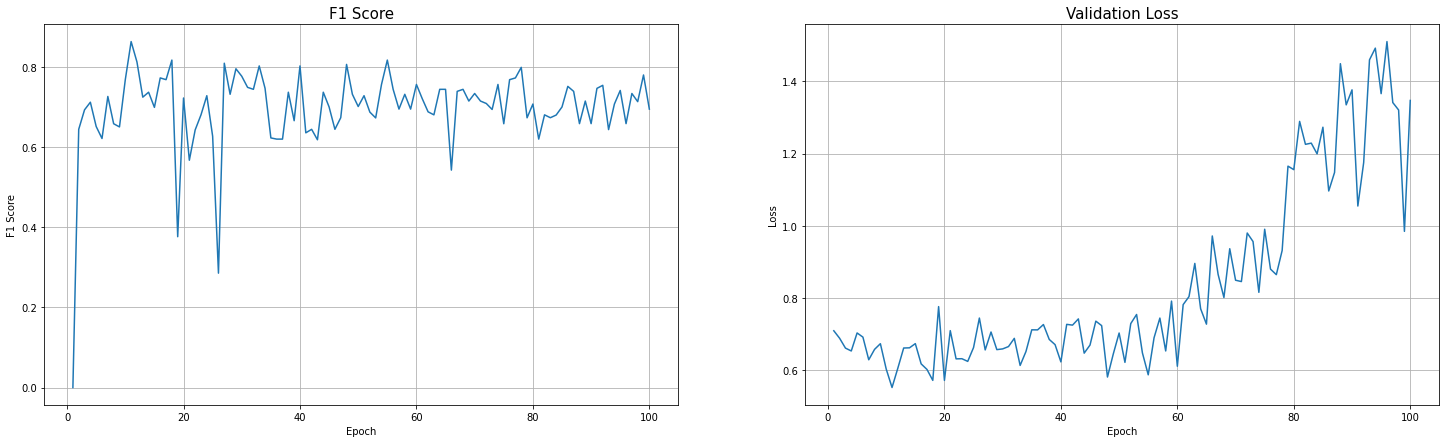

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(25, 7))
ax[0].set_title("F1 Score", fontsize=15)
val_f1scores = [elem.item() for elem in val_f1scores]
ax[0].plot(list(range(1, len(val_f1scores)+1)), val_f1scores)
ax[0].set_ylabel("F1 Score")
ax[0].set_xlabel("Epoch")
ax[0].grid(True)
ax[1].set_title("Validation Loss", fontsize=15)
ax[1].plot(list(range(1, len(val_losses)+1)), val_losses)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].grid(True)

In [ ]:
test_data['encoded'] = test_data['same_len_tokens'].apply(lambda x:encode(x))

In [ ]:
test_X = np.array([seq for seq in test_data['encoded'].values])
test_y = np.array([label for label in test_data['label_id'].values], dtype=np.float32)

test_dataset = Dataset(test_X, test_y)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)

In [ ]:
f1, test_loss = test(test_loader, model, loss_fn)

Test Error: 
 F1 Score: 0.617, Avg loss: 1.481773 

